In [ ]:
#Nesse notebook vamos tentar melhorar o modelo com algumas estratégias como por exemplo:
#1. Hyperparameter tuning com optuna
#2. Otimização de threshold via Precision-Recall
#3. Comparação de performance antes e depois


import pandas as pd
import numpy as np
import optuna
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, auc, classification_report,
    confusion_matrix, f1_score, average_precision_score
)
from xgboost import XGBClassifier
import xgboost as xgb

c:\Users\Arthur\Documents\Cursor\Projeto\Projeto datarisk\datarisk-case-ds-junior\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Lendo dados
data_model = pd.read_parquet('../data/final/data_model_final_columns_rmv.parquet', engine='fastparquet')


In [3]:
X = data_model.drop(columns=['INADIMPLENTE'])
y = data_model['INADIMPLENTE']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [5]:
# Para o tuning vou testar o optuna pela primeira vez, a função 'objective' define a meta da otimização do Optuna.
# Ela treina um modelo XGBoost com hiperparâmetros sugeridos pelo Optuna
# e avalia seu desempenho usando validação cruzada estratificada (5-folds)
# na métrica ROC AUC. Essa métrica é crucial para dados desbalanceados,
# pois avalia a capacidade de discriminação do modelo sem ser sensível à predominância
# de uma classe.
# O Optuna é escolhido por sua busca inteligente e eficiente (TPE), que explora o espaço
# de parâmetros de forma adaptativa, diferentemente do RandomizedSearchCV que usa
# amostragem aleatória, otimizando o processo de encontrar os melhores hiperparâmetros.

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 800),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 10.0, 25.0),
        "use_label_encoder": False,
        "eval_metric": "logloss",
        "random_state": 42,
        "n_jobs": -1
    }

    model = XGBClassifier(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    return cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1).mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Melhores parâmetros:")
print(study.best_params)

Best trial: 37. Best value: 0.959768:  39%|███▉      | 39/100 [09:27<20:37, 20.29s/it]

[I 2025-07-24 18:41:59,539] Trial 38 finished with value: 0.9594378616604047 and parameters: {'n_estimators': 303, 'learning_rate': 0.017044506420137568, 'max_depth': 11, 'min_child_weight': 10, 'gamma': 3.5881607052448614, 'subsample': 0.5118051030412076, 'colsample_bytree': 0.6505595383070132, 'reg_alpha': 3.797514967453383e-08, 'reg_lambda': 0.00021953825829302683, 'scale_pos_weight': 10.953423141513642}. Best is trial 37 with value: 0.95976763530555.


Best trial: 37. Best value: 0.959768:  40%|████      | 40/100 [09:39<18:03, 18.05s/it]

[I 2025-07-24 18:42:12,362] Trial 39 finished with value: 0.9592785582764651 and parameters: {'n_estimators': 505, 'learning_rate': 0.014187954534710868, 'max_depth': 10, 'min_child_weight': 8, 'gamma': 4.224971681159769, 'subsample': 0.5750422944202052, 'colsample_bytree': 0.72792220190002, 'reg_alpha': 1.1497428557269557e-07, 'reg_lambda': 0.002335535190783214, 'scale_pos_weight': 11.317142962706152}. Best is trial 37 with value: 0.95976763530555.


Best trial: 40. Best value: 0.960098:  41%|████      | 41/100 [09:55<17:00, 17.30s/it]

[I 2025-07-24 18:42:27,917] Trial 40 finished with value: 0.9600980498974616 and parameters: {'n_estimators': 649, 'learning_rate': 0.015889245665428712, 'max_depth': 11, 'min_child_weight': 9, 'gamma': 2.9414269796199077, 'subsample': 0.5327605775503739, 'colsample_bytree': 0.6285436344346996, 'reg_alpha': 6.352558609875788e-06, 'reg_lambda': 5.716942665609351e-07, 'scale_pos_weight': 13.254732423454538}. Best is trial 40 with value: 0.9600980498974616.


Best trial: 40. Best value: 0.960098:  42%|████▏     | 42/100 [10:10<16:10, 16.72s/it]

[I 2025-07-24 18:42:43,300] Trial 41 finished with value: 0.9599081005802603 and parameters: {'n_estimators': 652, 'learning_rate': 0.015797233393018868, 'max_depth': 11, 'min_child_weight': 10, 'gamma': 3.0288659248322594, 'subsample': 0.5318015834605416, 'colsample_bytree': 0.6419277216521018, 'reg_alpha': 2.7916271875119634e-06, 'reg_lambda': 1.4625358003236734e-07, 'scale_pos_weight': 13.512050067901765}. Best is trial 40 with value: 0.9600980498974616.


Best trial: 40. Best value: 0.960098:  43%|████▎     | 43/100 [10:26<15:36, 16.42s/it]

[I 2025-07-24 18:42:59,014] Trial 42 finished with value: 0.9598908386270424 and parameters: {'n_estimators': 642, 'learning_rate': 0.01630116560974943, 'max_depth': 11, 'min_child_weight': 9, 'gamma': 2.92949282339679, 'subsample': 0.5324026984472376, 'colsample_bytree': 0.6251795388332007, 'reg_alpha': 3.21897725803465e-06, 'reg_lambda': 3.1955995980085075e-07, 'scale_pos_weight': 13.325625519991451}. Best is trial 40 with value: 0.9600980498974616.


Best trial: 40. Best value: 0.960098:  44%|████▍     | 44/100 [10:41<14:48, 15.86s/it]

[I 2025-07-24 18:43:13,578] Trial 43 finished with value: 0.9599659911978413 and parameters: {'n_estimators': 571, 'learning_rate': 0.016911574752944872, 'max_depth': 12, 'min_child_weight': 9, 'gamma': 3.084138944557858, 'subsample': 0.5387292445636143, 'colsample_bytree': 0.6126482314290816, 'reg_alpha': 3.5274459974844747e-06, 'reg_lambda': 3.3318629402112864e-07, 'scale_pos_weight': 13.585974779358985}. Best is trial 40 with value: 0.9600980498974616.


Best trial: 40. Best value: 0.960098:  45%|████▌     | 45/100 [10:52<13:12, 14.41s/it]

[I 2025-07-24 18:43:24,596] Trial 44 finished with value: 0.9598235678450804 and parameters: {'n_estimators': 462, 'learning_rate': 0.02761705076477871, 'max_depth': 12, 'min_child_weight': 9, 'gamma': 2.9570080847928644, 'subsample': 0.5348601145877264, 'colsample_bytree': 0.6140734764957363, 'reg_alpha': 3.9411447357792386e-06, 'reg_lambda': 1.0115717924555154e-06, 'scale_pos_weight': 13.388675861047574}. Best is trial 40 with value: 0.9600980498974616.


Best trial: 40. Best value: 0.960098:  46%|████▌     | 46/100 [11:02<11:58, 13.31s/it]

[I 2025-07-24 18:43:35,336] Trial 45 finished with value: 0.9595613182554142 and parameters: {'n_estimators': 438, 'learning_rate': 0.028409581631747307, 'max_depth': 12, 'min_child_weight': 8, 'gamma': 2.938612548779244, 'subsample': 0.5454953241389965, 'colsample_bytree': 0.5828259290954824, 'reg_alpha': 7.900155974431847e-06, 'reg_lambda': 1.925952985249439e-07, 'scale_pos_weight': 13.550337967921312}. Best is trial 40 with value: 0.9600980498974616.


Best trial: 46. Best value: 0.960127:  47%|████▋     | 47/100 [11:16<11:54, 13.48s/it]

[I 2025-07-24 18:43:49,195] Trial 46 finished with value: 0.9601272524395237 and parameters: {'n_estimators': 548, 'learning_rate': 0.022964247259980038, 'max_depth': 12, 'min_child_weight': 9, 'gamma': 2.5644769145969364, 'subsample': 0.5361494689980699, 'colsample_bytree': 0.5354464803147196, 'reg_alpha': 2.821852932476212e-06, 'reg_lambda': 1.1977518652937516e-06, 'scale_pos_weight': 15.233640804240999}. Best is trial 46 with value: 0.9601272524395237.


Best trial: 46. Best value: 0.960127:  48%|████▊     | 48/100 [11:29<11:23, 13.15s/it]

[I 2025-07-24 18:44:01,591] Trial 47 finished with value: 0.959459853716577 and parameters: {'n_estimators': 558, 'learning_rate': 0.022924478092845067, 'max_depth': 9, 'min_child_weight': 9, 'gamma': 2.52058429376344, 'subsample': 0.591268806448316, 'colsample_bytree': 0.5246261980410196, 'reg_alpha': 3.889078574889448e-05, 'reg_lambda': 1.2243737661640408e-08, 'scale_pos_weight': 15.261175630841878}. Best is trial 46 with value: 0.9601272524395237.


Best trial: 46. Best value: 0.960127:  49%|████▉     | 49/100 [11:40<10:43, 12.61s/it]

[I 2025-07-24 18:44:12,949] Trial 48 finished with value: 0.9592644089101829 and parameters: {'n_estimators': 507, 'learning_rate': 0.017162690633944867, 'max_depth': 10, 'min_child_weight': 8, 'gamma': 3.4435206208956624, 'subsample': 0.5253476415044818, 'colsample_bytree': 0.573013694813769, 'reg_alpha': 1.7522666320132726e-06, 'reg_lambda': 4.3696250944905183e-07, 'scale_pos_weight': 14.467984170144382}. Best is trial 46 with value: 0.9601272524395237.


Best trial: 46. Best value: 0.960127:  50%|█████     | 50/100 [11:55<11:05, 13.30s/it]

[I 2025-07-24 18:44:27,861] Trial 49 finished with value: 0.9596978317188439 and parameters: {'n_estimators': 593, 'learning_rate': 0.022737591586658952, 'max_depth': 11, 'min_child_weight': 2, 'gamma': 2.64406481046068, 'subsample': 0.6236759658264821, 'colsample_bytree': 0.5394193245349637, 'reg_alpha': 2.4035648453928455e-05, 'reg_lambda': 5.67941677538373e-08, 'scale_pos_weight': 15.240570716647396}. Best is trial 46 with value: 0.9601272524395237.


Best trial: 46. Best value: 0.960127:  51%|█████     | 51/100 [11:59<08:42, 10.67s/it]

[I 2025-07-24 18:44:32,375] Trial 50 finished with value: 0.9559560500795221 and parameters: {'n_estimators': 382, 'learning_rate': 0.08328512808073442, 'max_depth': 4, 'min_child_weight': 9, 'gamma': 3.9149095754263783, 'subsample': 0.5821229301337273, 'colsample_bytree': 0.6226503158194053, 'reg_alpha': 2.939162368868265e-06, 'reg_lambda': 3.473107556179186e-06, 'scale_pos_weight': 13.943546094498661}. Best is trial 46 with value: 0.9601272524395237.


Best trial: 46. Best value: 0.960127:  52%|█████▏    | 52/100 [12:14<09:32, 11.93s/it]

[I 2025-07-24 18:44:47,275] Trial 51 finished with value: 0.9597567898002934 and parameters: {'n_estimators': 554, 'learning_rate': 0.029647558160413204, 'max_depth': 12, 'min_child_weight': 9, 'gamma': 2.996972281188383, 'subsample': 0.5393445990005546, 'colsample_bytree': 0.6118201276079375, 'reg_alpha': 2.5028212386096127e-06, 'reg_lambda': 9.0802884175493e-07, 'scale_pos_weight': 13.172430814551529}. Best is trial 46 with value: 0.9601272524395237.


Best trial: 46. Best value: 0.960127:  53%|█████▎    | 53/100 [12:29<09:58, 12.73s/it]

[I 2025-07-24 18:45:01,837] Trial 52 finished with value: 0.9599214313848086 and parameters: {'n_estimators': 475, 'learning_rate': 0.027007263465282063, 'max_depth': 12, 'min_child_weight': 8, 'gamma': 2.870282411352755, 'subsample': 0.5303879447663356, 'colsample_bytree': 0.5710662226673928, 'reg_alpha': 7.57717614259299e-05, 'reg_lambda': 1.8246530894062595e-07, 'scale_pos_weight': 15.63234681557504}. Best is trial 46 with value: 0.9601272524395237.


Best trial: 46. Best value: 0.960127:  54%|█████▍    | 54/100 [12:38<09:00, 11.74s/it]

[I 2025-07-24 18:45:11,292] Trial 53 finished with value: 0.9527375610135038 and parameters: {'n_estimators': 621, 'learning_rate': 0.17796678470308414, 'max_depth': 12, 'min_child_weight': 8, 'gamma': 2.5418249185658377, 'subsample': 0.5666080968695653, 'colsample_bytree': 0.5625847784462095, 'reg_alpha': 7.680251142844608e-05, 'reg_lambda': 1.2965022298970155e-07, 'scale_pos_weight': 15.66866722084274}. Best is trial 46 with value: 0.9601272524395237.


Best trial: 46. Best value: 0.960127:  55%|█████▌    | 55/100 [12:51<09:05, 12.12s/it]

[I 2025-07-24 18:45:24,282] Trial 54 finished with value: 0.9591603783464107 and parameters: {'n_estimators': 511, 'learning_rate': 0.03311024636506735, 'max_depth': 11, 'min_child_weight': 9, 'gamma': 2.4431066463018247, 'subsample': 0.5244470693521968, 'colsample_bytree': 0.5943208321969302, 'reg_alpha': 9.16851192342133e-06, 'reg_lambda': 3.0455260116338884e-08, 'scale_pos_weight': 14.757516596050078}. Best is trial 46 with value: 0.9601272524395237.


Best trial: 46. Best value: 0.960127:  56%|█████▌    | 56/100 [13:03<08:46, 11.96s/it]

[I 2025-07-24 18:45:35,883] Trial 55 finished with value: 0.9597620308680458 and parameters: {'n_estimators': 415, 'learning_rate': 0.02536622560733117, 'max_depth': 10, 'min_child_weight': 8, 'gamma': 2.8212036962695386, 'subsample': 0.5541659364899629, 'colsample_bytree': 0.6367775640001501, 'reg_alpha': 1.256418285064731e-06, 'reg_lambda': 4.390954991906871e-07, 'scale_pos_weight': 15.790789605136858}. Best is trial 46 with value: 0.9601272524395237.


Best trial: 46. Best value: 0.960127:  57%|█████▋    | 57/100 [13:12<07:58, 11.12s/it]

[I 2025-07-24 18:45:45,033] Trial 56 finished with value: 0.9589067270813271 and parameters: {'n_estimators': 475, 'learning_rate': 0.044910771467451635, 'max_depth': 12, 'min_child_weight': 9, 'gamma': 3.3898394692638316, 'subsample': 0.6281704744541171, 'colsample_bytree': 0.5450848230484311, 'reg_alpha': 1.7097011503418964e-05, 'reg_lambda': 6.654853747699409e-06, 'scale_pos_weight': 14.077436320993488}. Best is trial 46 with value: 0.9601272524395237.


Best trial: 57. Best value: 0.960191:  58%|█████▊    | 58/100 [13:27<08:37, 12.32s/it]

[I 2025-07-24 18:46:00,179] Trial 57 finished with value: 0.9601908348990758 and parameters: {'n_estimators': 580, 'learning_rate': 0.018196759439179075, 'max_depth': 11, 'min_child_weight': 7, 'gamma': 3.023949207089283, 'subsample': 0.521289455432699, 'colsample_bytree': 0.6659383011876805, 'reg_alpha': 2.4731068158971333e-07, 'reg_lambda': 1.0099545623384748e-06, 'scale_pos_weight': 18.041054283371363}. Best is trial 57 with value: 0.9601908348990758.


Best trial: 57. Best value: 0.960191:  59%|█████▉    | 59/100 [13:41<08:48, 12.88s/it]

[I 2025-07-24 18:46:14,357] Trial 58 finished with value: 0.9600253926441896 and parameters: {'n_estimators': 543, 'learning_rate': 0.017933651242821414, 'max_depth': 12, 'min_child_weight': 7, 'gamma': 3.8337249680398897, 'subsample': 0.5976275937342879, 'colsample_bytree': 0.6707854735260111, 'reg_alpha': 2.64161283740388e-07, 'reg_lambda': 1.9459050777649368e-06, 'scale_pos_weight': 19.65884728164837}. Best is trial 57 with value: 0.9601908348990758.


Best trial: 57. Best value: 0.960191:  60%|██████    | 60/100 [13:55<08:44, 13.10s/it]

[I 2025-07-24 18:46:27,977] Trial 59 finished with value: 0.9598220548596096 and parameters: {'n_estimators': 576, 'learning_rate': 0.021153672455691882, 'max_depth': 12, 'min_child_weight': 7, 'gamma': 3.8033233778930486, 'subsample': 0.5963479910307343, 'colsample_bytree': 0.6721639006277639, 'reg_alpha': 2.22489048943287e-07, 'reg_lambda': 1.5164646213246227e-06, 'scale_pos_weight': 19.833080834318526}. Best is trial 57 with value: 0.9601908348990758.


Best trial: 57. Best value: 0.960191:  61%|██████    | 61/100 [14:06<08:06, 12.46s/it]

[I 2025-07-24 18:46:38,957] Trial 60 finished with value: 0.9588670897352849 and parameters: {'n_estimators': 533, 'learning_rate': 0.01796403592126585, 'max_depth': 8, 'min_child_weight': 7, 'gamma': 1.651719010391881, 'subsample': 0.5003879013025215, 'colsample_bytree': 0.6734614817609231, 'reg_alpha': 4.577399696148718e-05, 'reg_lambda': 1.5001392002363437e-05, 'scale_pos_weight': 19.523845054506783}. Best is trial 57 with value: 0.9601908348990758.


Best trial: 57. Best value: 0.960191:  62%|██████▏   | 62/100 [14:21<08:23, 13.26s/it]

[I 2025-07-24 18:46:54,052] Trial 61 finished with value: 0.9599433759123379 and parameters: {'n_estimators': 615, 'learning_rate': 0.015228977948439469, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 4.6283312509438375, 'subsample': 0.5515276730357673, 'colsample_bytree': 0.5961300073739094, 'reg_alpha': 2.633810066920005e-07, 'reg_lambda': 9.343793995229819e-08, 'scale_pos_weight': 18.1659903001542}. Best is trial 57 with value: 0.9601908348990758.


Best trial: 57. Best value: 0.960191:  63%|██████▎   | 63/100 [14:34<08:04, 13.10s/it]

[I 2025-07-24 18:47:06,799] Trial 62 finished with value: 0.9594401080757974 and parameters: {'n_estimators': 528, 'learning_rate': 0.025496111950210096, 'max_depth': 12, 'min_child_weight': 5, 'gamma': 4.677462140238884, 'subsample': 0.5550838224194742, 'colsample_bytree': 0.594797802285902, 'reg_alpha': 2.686111735735145e-07, 'reg_lambda': 6.086530941374812e-08, 'scale_pos_weight': 18.074691788247556}. Best is trial 57 with value: 0.9601908348990758.


Best trial: 57. Best value: 0.960191:  64%|██████▍   | 64/100 [14:50<08:22, 13.97s/it]

[I 2025-07-24 18:47:22,804] Trial 63 finished with value: 0.959694826317752 and parameters: {'n_estimators': 604, 'learning_rate': 0.01446472920556783, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 4.3468461754128445, 'subsample': 0.5187976789743063, 'colsample_bytree': 0.5544281119866614, 'reg_alpha': 2.516703039503172e-07, 'reg_lambda': 2.0854578070148812e-06, 'scale_pos_weight': 21.057445290336876}. Best is trial 57 with value: 0.9601908348990758.


Best trial: 57. Best value: 0.960191:  65%|██████▌   | 65/100 [15:06<08:33, 14.67s/it]

[I 2025-07-24 18:47:39,109] Trial 64 finished with value: 0.9599532054015398 and parameters: {'n_estimators': 574, 'learning_rate': 0.01835774131092757, 'max_depth': 12, 'min_child_weight': 7, 'gamma': 4.633515189890663, 'subsample': 0.5501140878108073, 'colsample_bytree': 0.5241425678814052, 'reg_alpha': 1.1030624760533268e-06, 'reg_lambda': 6.412311996099495e-07, 'scale_pos_weight': 18.874544201453872}. Best is trial 57 with value: 0.9601908348990758.


Best trial: 57. Best value: 0.960191:  66%|██████▌   | 66/100 [15:20<08:07, 14.34s/it]

[I 2025-07-24 18:47:52,673] Trial 65 finished with value: 0.960021371134282 and parameters: {'n_estimators': 573, 'learning_rate': 0.01826678487729286, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 4.583334289810669, 'subsample': 0.5729429207194575, 'colsample_bytree': 0.5054595139864705, 'reg_alpha': 9.084462161746087e-07, 'reg_lambda': 5.043930539296343e-06, 'scale_pos_weight': 18.689583281767447}. Best is trial 57 with value: 0.9601908348990758.


Best trial: 57. Best value: 0.960191:  67%|██████▋   | 67/100 [15:34<07:52, 14.31s/it]

[I 2025-07-24 18:48:06,910] Trial 66 finished with value: 0.9600080248733587 and parameters: {'n_estimators': 571, 'learning_rate': 0.01926221447264172, 'max_depth': 11, 'min_child_weight': 4, 'gamma': 4.946205901796857, 'subsample': 0.5774607438824982, 'colsample_bytree': 0.5070802373276586, 'reg_alpha': 7.891709465540623e-07, 'reg_lambda': 4.929012637622669e-06, 'scale_pos_weight': 18.638575721332817}. Best is trial 57 with value: 0.9601908348990758.


Best trial: 57. Best value: 0.960191:  68%|██████▊   | 68/100 [15:50<07:54, 14.84s/it]

[I 2025-07-24 18:48:22,991] Trial 67 finished with value: 0.960091890479856 and parameters: {'n_estimators': 547, 'learning_rate': 0.021225293800801893, 'max_depth': 11, 'min_child_weight': 4, 'gamma': 4.180066987264883, 'subsample': 0.5798996825897532, 'colsample_bytree': 0.5196449813899742, 'reg_alpha': 5.883936364289416e-07, 'reg_lambda': 3.714005519367005e-06, 'scale_pos_weight': 20.84474631946201}. Best is trial 57 with value: 0.9601908348990758.


Best trial: 57. Best value: 0.960191:  69%|██████▉   | 69/100 [16:03<07:19, 14.17s/it]

[I 2025-07-24 18:48:35,596] Trial 68 finished with value: 0.9586234027417756 and parameters: {'n_estimators': 552, 'learning_rate': 0.033801433638954895, 'max_depth': 10, 'min_child_weight': 4, 'gamma': 4.11762327015821, 'subsample': 0.5803934144163122, 'colsample_bytree': 0.5082805056264171, 'reg_alpha': 5.938231614896697e-07, 'reg_lambda': 7.055200974048487e-06, 'scale_pos_weight': 20.844784852355147}. Best is trial 57 with value: 0.9601908348990758.


Best trial: 57. Best value: 0.960191:  70%|███████   | 70/100 [16:15<06:44, 13.47s/it]

[I 2025-07-24 18:48:47,442] Trial 69 finished with value: 0.9593902418329823 and parameters: {'n_estimators': 490, 'learning_rate': 0.02244313421254804, 'max_depth': 9, 'min_child_weight': 5, 'gamma': 4.995082764665714, 'subsample': 0.6129084864979808, 'colsample_bytree': 0.5012771332278065, 'reg_alpha': 1.1665584540675433e-07, 'reg_lambda': 1.9462524693584416e-05, 'scale_pos_weight': 18.766760985734912}. Best is trial 57 with value: 0.9601908348990758.


Best trial: 57. Best value: 0.960191:  71%|███████   | 71/100 [16:28<06:33, 13.58s/it]

[I 2025-07-24 18:49:01,287] Trial 70 finished with value: 0.9597045608888106 and parameters: {'n_estimators': 629, 'learning_rate': 0.020951820902486713, 'max_depth': 11, 'min_child_weight': 3, 'gamma': 4.8073006262608695, 'subsample': 0.6388509708349539, 'colsample_bytree': 0.528590441296896, 'reg_alpha': 2.270489553769509e-08, 'reg_lambda': 2.81578968958159e-06, 'scale_pos_weight': 20.58553668184646}. Best is trial 57 with value: 0.9601908348990758.


Best trial: 57. Best value: 0.960191:  72%|███████▏  | 72/100 [16:43<06:27, 13.83s/it]

[I 2025-07-24 18:49:15,688] Trial 71 finished with value: 0.9596857063724012 and parameters: {'n_estimators': 568, 'learning_rate': 0.019492023122250787, 'max_depth': 11, 'min_child_weight': 4, 'gamma': 4.358309547174121, 'subsample': 0.5718338053466584, 'colsample_bytree': 0.5180067758205802, 'reg_alpha': 4.8659788641609185e-06, 'reg_lambda': 5.520404731919204e-06, 'scale_pos_weight': 23.007699067632572}. Best is trial 57 with value: 0.9601908348990758.


Best trial: 57. Best value: 0.960191:  73%|███████▎  | 73/100 [17:00<06:39, 14.80s/it]

[I 2025-07-24 18:49:32,730] Trial 72 finished with value: 0.9597879393122237 and parameters: {'n_estimators': 594, 'learning_rate': 0.011475147776587216, 'max_depth': 11, 'min_child_weight': 5, 'gamma': 4.044614407550591, 'subsample': 0.5888533651697407, 'colsample_bytree': 0.5364252533896394, 'reg_alpha': 1.476808496605515e-06, 'reg_lambda': 1.4467354964999286e-05, 'scale_pos_weight': 21.43841761807402}. Best is trial 57 with value: 0.9601908348990758.


Best trial: 57. Best value: 0.960191:  74%|███████▍  | 74/100 [17:14<06:18, 14.54s/it]

[I 2025-07-24 18:49:46,697] Trial 73 finished with value: 0.9601339429743504 and parameters: {'n_estimators': 533, 'learning_rate': 0.017945291037567482, 'max_depth': 12, 'min_child_weight': 3, 'gamma': 4.4962409934938465, 'subsample': 0.7338029289180388, 'colsample_bytree': 0.5528896777505674, 'reg_alpha': 4.886876908617748e-07, 'reg_lambda': 1.4052008700911004e-06, 'scale_pos_weight': 17.630024107861917}. Best is trial 57 with value: 0.9601908348990758.


Best trial: 57. Best value: 0.960191:  75%|███████▌  | 75/100 [17:29<06:05, 14.64s/it]

[I 2025-07-24 18:50:01,556] Trial 74 finished with value: 0.9596768040569845 and parameters: {'n_estimators': 534, 'learning_rate': 0.013638302822837636, 'max_depth': 11, 'min_child_weight': 3, 'gamma': 4.440145794956576, 'subsample': 0.8054541302673032, 'colsample_bytree': 0.5630498384576883, 'reg_alpha': 4.1723622152959226e-07, 'reg_lambda': 1.6628122183577688e-06, 'scale_pos_weight': 17.61715311837651}. Best is trial 57 with value: 0.9601908348990758.


Best trial: 57. Best value: 0.960191:  76%|███████▌  | 76/100 [17:39<05:17, 13.22s/it]

[I 2025-07-24 18:50:11,459] Trial 75 finished with value: 0.9582142041310131 and parameters: {'n_estimators': 542, 'learning_rate': 0.018584829579123666, 'max_depth': 7, 'min_child_weight': 3, 'gamma': 4.757744866431516, 'subsample': 0.6154653731200094, 'colsample_bytree': 0.5506095018501673, 'reg_alpha': 1.5923895288412245e-07, 'reg_lambda': 3.684205027883562e-05, 'scale_pos_weight': 18.984159839138037}. Best is trial 57 with value: 0.9601908348990758.


Best trial: 57. Best value: 0.960191:  77%|███████▋  | 77/100 [17:53<05:09, 13.44s/it]

[I 2025-07-24 18:50:25,412] Trial 76 finished with value: 0.9595500946081466 and parameters: {'n_estimators': 511, 'learning_rate': 0.021259315181432613, 'max_depth': 11, 'min_child_weight': 2, 'gamma': 4.52762726114299, 'subsample': 0.7480771590728236, 'colsample_bytree': 0.5158062154394395, 'reg_alpha': 6.038836128901486e-08, 'reg_lambda': 7.799625958953966e-05, 'scale_pos_weight': 20.244678506780055}. Best is trial 57 with value: 0.9601908348990758.


Best trial: 57. Best value: 0.960191:  78%|███████▊  | 78/100 [18:03<04:35, 12.54s/it]

[I 2025-07-24 18:50:35,872] Trial 77 finished with value: 0.9589774622363916 and parameters: {'n_estimators': 330, 'learning_rate': 0.02518353244638384, 'max_depth': 11, 'min_child_weight': 4, 'gamma': 4.213453694811083, 'subsample': 0.6019420381580376, 'colsample_bytree': 0.7422110420261848, 'reg_alpha': 9.181775457072976e-07, 'reg_lambda': 6.613670260472687e-07, 'scale_pos_weight': 17.063314319326665}. Best is trial 57 with value: 0.9601908348990758.


Best trial: 57. Best value: 0.960191:  79%|███████▉  | 79/100 [18:19<04:42, 13.47s/it]

[I 2025-07-24 18:50:51,489] Trial 78 finished with value: 0.9592824296519818 and parameters: {'n_estimators': 600, 'learning_rate': 0.014740379396142412, 'max_depth': 10, 'min_child_weight': 3, 'gamma': 4.939450041547583, 'subsample': 0.6752963182896761, 'colsample_bytree': 0.6852810267757617, 'reg_alpha': 3.830190942901962e-07, 'reg_lambda': 4.399373218402745e-06, 'scale_pos_weight': 19.326700429604003}. Best is trial 57 with value: 0.9601908348990758.


Best trial: 79. Best value: 0.96035:  80%|████████  | 80/100 [18:39<05:13, 15.65s/it] 

[I 2025-07-24 18:51:12,254] Trial 79 finished with value: 0.9603500944880204 and parameters: {'n_estimators': 685, 'learning_rate': 0.011327841661857642, 'max_depth': 12, 'min_child_weight': 5, 'gamma': 3.825168561400779, 'subsample': 0.5684561870260696, 'colsample_bytree': 0.5016119596224199, 'reg_alpha': 1.0801043147735258e-05, 'reg_lambda': 1.7885793567884178e-06, 'scale_pos_weight': 17.80334738070724}. Best is trial 79 with value: 0.9603500944880204.


Best trial: 80. Best value: 0.960422:  81%|████████  | 81/100 [19:00<05:26, 17.16s/it]

[I 2025-07-24 18:51:32,922] Trial 80 finished with value: 0.9604217347860283 and parameters: {'n_estimators': 700, 'learning_rate': 0.011253022265730024, 'max_depth': 12, 'min_child_weight': 5, 'gamma': 3.8560246780682643, 'subsample': 0.8364190002708054, 'colsample_bytree': 0.5328938101782195, 'reg_alpha': 6.912878010466149e-06, 'reg_lambda': 1.0795575277138339e-05, 'scale_pos_weight': 16.65609075923629}. Best is trial 80 with value: 0.9604217347860283.


Best trial: 80. Best value: 0.960422:  82%|████████▏ | 82/100 [19:21<05:30, 18.37s/it]

[I 2025-07-24 18:51:54,100] Trial 81 finished with value: 0.96012884953643 and parameters: {'n_estimators': 700, 'learning_rate': 0.010928276813038082, 'max_depth': 12, 'min_child_weight': 5, 'gamma': 3.8210264558429503, 'subsample': 0.9515023754553188, 'colsample_bytree': 0.5367049275733723, 'reg_alpha': 9.003634926221715e-06, 'reg_lambda': 1.0841629429327549e-05, 'scale_pos_weight': 17.756544616597285}. Best is trial 80 with value: 0.9604217347860283.


Best trial: 80. Best value: 0.960422:  83%|████████▎ | 83/100 [19:42<05:24, 19.11s/it]

[I 2025-07-24 18:52:14,940] Trial 82 finished with value: 0.960158424562055 and parameters: {'n_estimators': 683, 'learning_rate': 0.011049504528342675, 'max_depth': 12, 'min_child_weight': 5, 'gamma': 3.831030432584719, 'subsample': 0.9483053358050639, 'colsample_bytree': 0.5350649615574684, 'reg_alpha': 1.5164167344454399e-05, 'reg_lambda': 1.5007569464394561e-06, 'scale_pos_weight': 16.230942958952422}. Best is trial 80 with value: 0.9604217347860283.


Best trial: 80. Best value: 0.960422:  84%|████████▍ | 84/100 [20:04<05:20, 20.03s/it]

[I 2025-07-24 18:52:37,111] Trial 83 finished with value: 0.9602162092808569 and parameters: {'n_estimators': 700, 'learning_rate': 0.01145144558733617, 'max_depth': 12, 'min_child_weight': 5, 'gamma': 3.712750263247656, 'subsample': 0.9555210357548652, 'colsample_bytree': 0.5384260832906941, 'reg_alpha': 8.639214914746279e-06, 'reg_lambda': 1.1122997221353808e-06, 'scale_pos_weight': 16.290115236886805}. Best is trial 80 with value: 0.9604217347860283.


Best trial: 80. Best value: 0.960422:  85%|████████▌ | 85/100 [20:25<05:03, 20.25s/it]

[I 2025-07-24 18:52:57,903] Trial 84 finished with value: 0.9599798924968421 and parameters: {'n_estimators': 701, 'learning_rate': 0.011111849407056463, 'max_depth': 12, 'min_child_weight': 5, 'gamma': 3.6864957519926382, 'subsample': 0.9496971502680013, 'colsample_bytree': 0.5829904618777381, 'reg_alpha': 1.2342191501272017e-05, 'reg_lambda': 1.2113851075528227e-06, 'scale_pos_weight': 16.269027524724827}. Best is trial 80 with value: 0.9604217347860283.


Best trial: 80. Best value: 0.960422:  86%|████████▌ | 86/100 [20:50<05:03, 21.67s/it]

[I 2025-07-24 18:53:22,874] Trial 85 finished with value: 0.9602805960168815 and parameters: {'n_estimators': 681, 'learning_rate': 0.011095402708251295, 'max_depth': 12, 'min_child_weight': 5, 'gamma': 3.4296319703753806, 'subsample': 0.8971776801567508, 'colsample_bytree': 0.5334421421915385, 'reg_alpha': 6.350502908430753e-06, 'reg_lambda': 1.1084847537982266e-05, 'scale_pos_weight': 16.70617160228827}. Best is trial 80 with value: 0.9604217347860283.


Best trial: 80. Best value: 0.960422:  87%|████████▋ | 87/100 [21:17<05:02, 23.23s/it]

[I 2025-07-24 18:53:49,757] Trial 86 finished with value: 0.9602834240117188 and parameters: {'n_estimators': 727, 'learning_rate': 0.011119657365754137, 'max_depth': 12, 'min_child_weight': 5, 'gamma': 3.4273780675846828, 'subsample': 0.9035619012798786, 'colsample_bytree': 0.5400225361858254, 'reg_alpha': 1.9861615804954252e-05, 'reg_lambda': 0.00013474724138093594, 'scale_pos_weight': 16.855271775729253}. Best is trial 80 with value: 0.9604217347860283.


Best trial: 80. Best value: 0.960422:  88%|████████▊ | 88/100 [21:40<04:37, 23.16s/it]

[I 2025-07-24 18:54:12,737] Trial 87 finished with value: 0.9602735826722426 and parameters: {'n_estimators': 729, 'learning_rate': 0.011071663578499358, 'max_depth': 12, 'min_child_weight': 5, 'gamma': 3.420094717455258, 'subsample': 0.9017714757561982, 'colsample_bytree': 0.5514902633313062, 'reg_alpha': 2.327775366103114e-05, 'reg_lambda': 8.605583812539281e-05, 'scale_pos_weight': 16.762197800314112}. Best is trial 80 with value: 0.9604217347860283.


Best trial: 80. Best value: 0.960422:  89%|████████▉ | 89/100 [22:01<04:08, 22.62s/it]

[I 2025-07-24 18:54:34,090] Trial 88 finished with value: 0.9602593851975586 and parameters: {'n_estimators': 729, 'learning_rate': 0.012708742499351269, 'max_depth': 12, 'min_child_weight': 5, 'gamma': 3.405366451771403, 'subsample': 0.9024298943524242, 'colsample_bytree': 0.5505301723636871, 'reg_alpha': 2.1821481232411315e-05, 'reg_lambda': 0.000752025453874696, 'scale_pos_weight': 16.796519730041336}. Best is trial 80 with value: 0.9604217347860283.


Best trial: 80. Best value: 0.960422:  90%|█████████ | 90/100 [22:24<03:46, 22.60s/it]

[I 2025-07-24 18:54:56,665] Trial 89 finished with value: 0.9602292538120055 and parameters: {'n_estimators': 729, 'learning_rate': 0.012521267466582197, 'max_depth': 12, 'min_child_weight': 5, 'gamma': 3.4637408221409736, 'subsample': 0.8940814872294774, 'colsample_bytree': 0.564582401314157, 'reg_alpha': 2.4554385030196446e-05, 'reg_lambda': 9.876143095744703e-05, 'scale_pos_weight': 16.744899573356893}. Best is trial 80 with value: 0.9604217347860283.


Best trial: 80. Best value: 0.960422:  91%|█████████ | 91/100 [22:45<03:20, 22.29s/it]

[I 2025-07-24 18:55:18,235] Trial 90 finished with value: 0.9599756567775787 and parameters: {'n_estimators': 726, 'learning_rate': 0.012531944764522155, 'max_depth': 12, 'min_child_weight': 5, 'gamma': 3.4760686783778247, 'subsample': 0.896801227590853, 'colsample_bytree': 0.5707153934800904, 'reg_alpha': 0.00013291483691719338, 'reg_lambda': 0.00013024649526108235, 'scale_pos_weight': 17.017565150864012}. Best is trial 80 with value: 0.9604217347860283.


Best trial: 80. Best value: 0.960422:  92%|█████████▏| 92/100 [23:08<03:00, 22.50s/it]

[I 2025-07-24 18:55:41,218] Trial 91 finished with value: 0.9602587443667442 and parameters: {'n_estimators': 686, 'learning_rate': 0.010971800096410505, 'max_depth': 12, 'min_child_weight': 5, 'gamma': 3.329221677333111, 'subsample': 0.841141788342152, 'colsample_bytree': 0.5595232383123543, 'reg_alpha': 2.482656863307903e-05, 'reg_lambda': 0.0005262221153378658, 'scale_pos_weight': 16.625511055572915}. Best is trial 80 with value: 0.9604217347860283.


Best trial: 92. Best value: 0.960451:  93%|█████████▎| 93/100 [23:30<02:35, 22.23s/it]

[I 2025-07-24 18:56:02,799] Trial 92 finished with value: 0.9604506719260147 and parameters: {'n_estimators': 727, 'learning_rate': 0.013261033440069573, 'max_depth': 12, 'min_child_weight': 5, 'gamma': 3.27431336221779, 'subsample': 0.8802134470359815, 'colsample_bytree': 0.5595566879701452, 'reg_alpha': 3.4718875369101284e-05, 'reg_lambda': 0.0009720233381099398, 'scale_pos_weight': 16.606920522644185}. Best is trial 92 with value: 0.9604506719260147.


Best trial: 92. Best value: 0.960451:  94%|█████████▍| 94/100 [23:56<02:19, 23.29s/it]

[I 2025-07-24 18:56:28,556] Trial 93 finished with value: 0.9602846868195851 and parameters: {'n_estimators': 737, 'learning_rate': 0.013015736658322861, 'max_depth': 12, 'min_child_weight': 5, 'gamma': 3.335068926481673, 'subsample': 0.8428496987822789, 'colsample_bytree': 0.559674768364078, 'reg_alpha': 2.9601186755312248e-05, 'reg_lambda': 0.0007641484560895882, 'scale_pos_weight': 16.805043314140903}. Best is trial 92 with value: 0.9604506719260147.


Best trial: 92. Best value: 0.960451:  95%|█████████▌| 95/100 [24:21<01:59, 24.00s/it]

[I 2025-07-24 18:56:54,219] Trial 94 finished with value: 0.9603464335070452 and parameters: {'n_estimators': 737, 'learning_rate': 0.01295496210875677, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 3.341224420191164, 'subsample': 0.8460300529000061, 'colsample_bytree': 0.5566975081186587, 'reg_alpha': 3.157963336212112e-05, 'reg_lambda': 0.0006549492201480018, 'scale_pos_weight': 16.709055127268098}. Best is trial 92 with value: 0.9604506719260147.


Best trial: 95. Best value: 0.960697:  96%|█████████▌| 96/100 [24:45<01:35, 23.88s/it]

[I 2025-07-24 18:57:17,816] Trial 95 finished with value: 0.9606973101827199 and parameters: {'n_estimators': 776, 'learning_rate': 0.01327110308444624, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 3.3436730561652412, 'subsample': 0.8487058774391942, 'colsample_bytree': 0.5803279718634845, 'reg_alpha': 5.059795950491946e-05, 'reg_lambda': 0.0005264079299133501, 'scale_pos_weight': 17.344063542015732}. Best is trial 95 with value: 0.9606973101827199.


Best trial: 95. Best value: 0.960697:  97%|█████████▋| 97/100 [25:05<01:08, 22.81s/it]

[I 2025-07-24 18:57:38,040] Trial 96 finished with value: 0.9604464266755132 and parameters: {'n_estimators': 781, 'learning_rate': 0.013205872046345626, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 3.5815872822663306, 'subsample': 0.853855652452558, 'colsample_bytree': 0.5893406727504225, 'reg_alpha': 0.0008811635413124048, 'reg_lambda': 0.0007305425337128287, 'scale_pos_weight': 17.110001285146947}. Best is trial 95 with value: 0.9606973101827199.


Best trial: 95. Best value: 0.960697:  98%|█████████▊| 98/100 [25:25<00:43, 21.93s/it]

[I 2025-07-24 18:57:58,023] Trial 97 finished with value: 0.9605486020684569 and parameters: {'n_estimators': 776, 'learning_rate': 0.01372941527345128, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 3.5728178339453196, 'subsample': 0.8463860775828316, 'colsample_bytree': 0.5840454486352488, 'reg_alpha': 0.0007045614560130812, 'reg_lambda': 0.0011625482901807494, 'scale_pos_weight': 17.122532221105473}. Best is trial 95 with value: 0.9606973101827199.


Best trial: 95. Best value: 0.960697:  99%|█████████▉| 99/100 [25:36<00:18, 18.54s/it]

[I 2025-07-24 18:58:08,611] Trial 98 finished with value: 0.9570338044614605 and parameters: {'n_estimators': 770, 'learning_rate': 0.013638215386587129, 'max_depth': 5, 'min_child_weight': 6, 'gamma': 3.1884144116470194, 'subsample': 0.8520783127388233, 'colsample_bytree': 0.5748618452026434, 'reg_alpha': 0.0010612150620471572, 'reg_lambda': 0.00041330502099435414, 'scale_pos_weight': 17.16890644080043}. Best is trial 95 with value: 0.9606973101827199.


Best trial: 95. Best value: 0.960697: 100%|██████████| 100/100 [25:56<00:00, 15.57s/it]

[I 2025-07-24 18:58:28,991] Trial 99 finished with value: 0.9603755915584014 and parameters: {'n_estimators': 788, 'learning_rate': 0.013604356923870468, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 3.6410815811389696, 'subsample': 0.8254088088605941, 'colsample_bytree': 0.5829874114129479, 'reg_alpha': 0.004113671503078526, 'reg_lambda': 0.0011837207585841537, 'scale_pos_weight': 17.41272466283143}. Best is trial 95 with value: 0.9606973101827199.
Melhores parâmetros:
{'n_estimators': 776, 'learning_rate': 0.01327110308444624, 'max_depth': 12, 'min_child_weight': 6, 'gamma': 3.3436730561652412, 'subsample': 0.8487058774391942, 'colsample_bytree': 0.5803279718634845, 'reg_alpha': 5.059795950491946e-05, 'reg_lambda': 0.0005264079299133501, 'scale_pos_weight': 17.344063542015732}


In [6]:
best_model = XGBClassifier(**study.best_params, use_label_encoder=False, eval_metric='logloss', n_jobs=-1, random_state=42)
best_model.fit(X_train, y_train)

c:\Users\Arthur\Documents\Cursor\Projeto\Projeto datarisk\datarisk-case-ds-junior\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:58:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5803279718634845, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=3.3436730561652412, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01327110308444624,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=776, n_jobs=-1,
              num_parallel_tree=None, ...)

In [7]:
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC AUC (teste): {roc_auc:.6f}")

ROC AUC (teste): 0.963312


In [8]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"Melhor threshold pelo F1: {best_threshold:.4f}")
print(f"Precision-Recall AUC: {pr_auc:.4f}")

Melhor threshold pelo F1: 0.7887
Precision-Recall AUC: 0.7524


In [9]:
y_pred_opt = (y_pred_prob >= best_threshold).astype(int)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_opt))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_opt))

Confusion Matrix:
[[14129   263]
 [  323   759]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     14392
           1       0.74      0.70      0.72      1082

    accuracy                           0.96     15474
   macro avg       0.86      0.84      0.85     15474
weighted avg       0.96      0.96      0.96     15474



In [10]:
model_old = XGBClassifier()
model_old.load_model("../models/xgb_inadimplencia_v1.json")
y_pred_prob_old = model_old.predict_proba(X_test)[:, 1]
y_pred_old = (y_pred_prob_old >= 0.5).astype(int)

def avaliar_modelo(nome, y_true, y_pred, y_prob):
    print(f"\n{nome}")
    print("ROC AUC:", roc_auc_score(y_true, y_prob))
    print("PR AUC:", average_precision_score(y_true, y_prob))
    print(classification_report(y_true, y_pred))
    return confusion_matrix(y_true, y_pred)

cm_old = avaliar_modelo("Modelo Antigo", y_test, y_pred_old, y_pred_prob_old)
cm_opt = avaliar_modelo("Modelo Otimizado", y_test, y_pred_opt, y_pred_prob_old)


Modelo Antigo
ROC AUC: 0.9516029713056854
PR AUC: 0.7279800124279566
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     14392
           1       0.54      0.82      0.65      1082

    accuracy                           0.94     15474
   macro avg       0.76      0.88      0.81     15474
weighted avg       0.95      0.94      0.94     15474


Modelo Otimizado
ROC AUC: 0.9516029713056854
PR AUC: 0.7279800124279566
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     14392
           1       0.74      0.70      0.72      1082

    accuracy                           0.96     15474
   macro avg       0.86      0.84      0.85     15474
weighted avg       0.96      0.96      0.96     15474



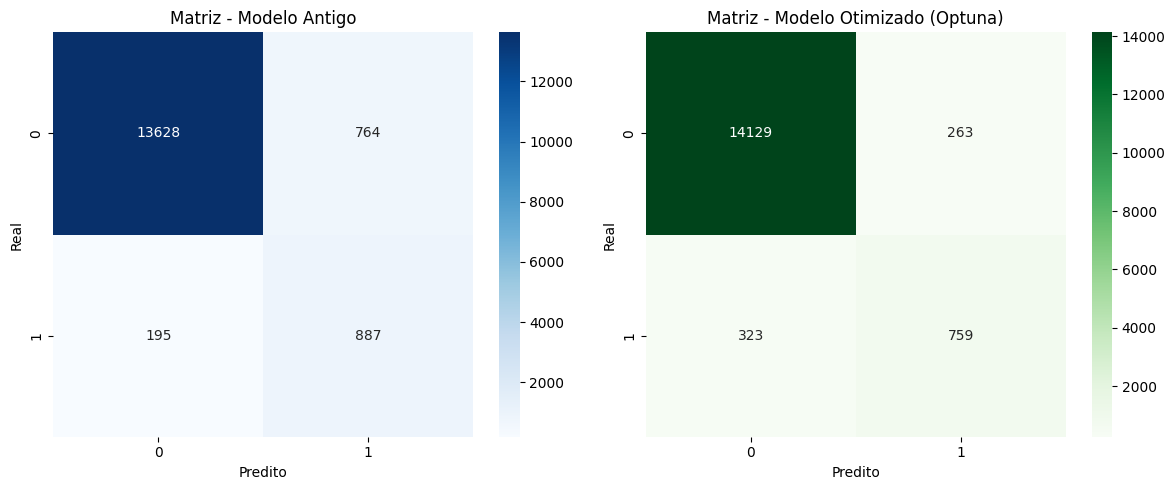

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_old, annot=True, fmt="d", cmap="Blues", ax=axs[0])
axs[0].set_title("Matriz - Modelo Antigo")
axs[0].set_xlabel("Predito")
axs[0].set_ylabel("Real")

sns.heatmap(cm_opt, annot=True, fmt="d", cmap="Greens", ax=axs[1])
axs[1].set_title("Matriz - Modelo Otimizado (Optuna)")
axs[1].set_xlabel("Predito")
axs[1].set_ylabel("Real")

plt.tight_layout()
plt.savefig("comparacao_matrizes_confusao.png")
plt.show()

In [12]:
#print("\n--- Comparando com modelo anterior ---")
#old_model = xgb.XGBClassifier()
#old_model.load_model('../models/xgb_inadimplencia_v1.json')
#old_pred_prob = old_model.predict_proba(X_test)[:, 1]
#old_roc_auc = roc_auc_score(y_test, old_pred_prob)
#old_precision, old_recall, _ = precision_recall_curve(y_test, old_pred_prob)
#old_pr_auc = auc(old_recall, old_precision)
#
#print(f"Modelo anterior - ROC AUC: {old_roc_auc:.4f}")
#print(f"Modelo anterior - PR AUC: {old_pr_auc:.4f}")
#print(f"Modelo novo - ROC AUC: {roc_auc:.4f}")
#print(f"Modelo novo - PR AUC: {pr_auc:.4f}")


In [ ]:
#Após o tuning, o modelo apresentou melhorias significativas nas métricas de classificação, especialmente no desempenho da classe minoritária (inadimplentes). 
#Embora as métricas globais de ROC AUC e PR AUC tenham se mantido constantes, houve um avanço importante no precision (de 0.54 para 0.74) e no f1-score (de 0.65 para 0.72) da classe 1, 
#indicando uma maior capacidade do modelo otimizado em identificar corretamente os casos de inadimplência com menor taxa de falsos positivos. 
#Além disso, o aumento na acurácia geral (de 0.94 para 0.96) e nas médias ponderadas reforça a melhora da performance do modelo como um todo. 
#Esses ganhos mostram que o tuning contribuiu para um equilíbrio mais adequado entre sensibilidade e precisão

In [13]:
best_model.save_model('../models/xgb_inadimplencia_optuna.json')
print("Modelo final salvo em: ../models/xgb_inadimplencia_optuna.json")

Modelo final salvo em: ../models/xgb_inadimplencia_optuna.json
